In [1]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
from torch.autograd import Variable
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

In [33]:
%matplotlib inline
torch.manual_seed(1)
os.makedirs('images', exist_ok=True)

In [34]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, 
                            transform=transforms.Compose([transforms.ToTensor(),
                                                         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
                                                        ))

In [35]:
def weight_init(layer):
    if type(m) in [nn.Conv2d, nn.Linear]:
        layer.data = nn.init.xavier_normal(layer.data.size())
        if layer.bias:
            layer.bias.data = nn.init.zeros_(layer.bias.size())

In [36]:
len(train_dataset)

60000

tensor(5)


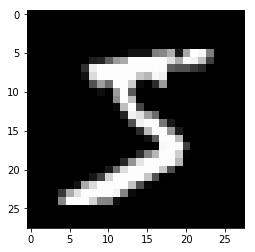

In [37]:
plt.imshow(train_dataset.train_data[0].numpy(), cmap='gray')
print(train_dataset.train_labels[0])

In [73]:
image_size = (1, 28, 28)
latent_dim = 100
batch_size = 128
iterations = 50000
n_epochs = iterations/(len(train_dataset)/batch_size)
n_epochs = int(n_epochs)
print(n_epochs)

106


In [74]:
train_loader = data.DataLoader(train_dataset, batch_size, shuffle=True)

In [75]:
class Discriminator(nn.Module):
    def __init__(self, img_sz):
        super(Discriminator, self).__init__()
                
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_sz)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.model(out)        
        return out

In [76]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_sz):
        super(Generator, self).__init__()
        self.img_sz = img_sz
        
        def fully_connected(input_dim, output_dim, batch_norm=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *fully_connected(latent_dim, 128, batch_norm=True),
            *fully_connected(128, 256),
            *fully_connected(256, 512),
            *fully_connected(512, 1024),
            nn.Linear(1024, int(np.prod(img_sz))),
            nn.Tanh())
    
    def forward(self, z):
        z = self.model(z)
        z = z.view(z.size(0), *self.img_sz)
        return z

In [77]:
generator = Generator(latent_dim=latent_dim, img_sz=image_size)
discriminator = Discriminator(img_sz=image_size)

In [78]:
adversarial_criterion = nn.BCELoss()

In [79]:
learning_rate = 0.00001
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=learning_rate)

In [80]:
Tensor = torch.FloatTensor

In [81]:
gen_loss = []
dis_loss = []
for epoch in range(n_epochs):
    counter=0
    for i, (images, labels) in enumerate(train_loader):
        valid = Variable(Tensor(images.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(images.size(0), 1).fill_(0.0), requires_grad=False)
        
        real_images = Variable(images.type(Tensor))
        z = np.random.normal(0, 1, (images.size(0), latent_dim))
        z = Variable(Tensor(z))
        gen_images = generator(z)
        
        
        # Generator training
        optimizer_gen.zero_grad()
        generator_loss = adversarial_criterion(discriminator(gen_images), valid)
        gen_loss.append(generator_loss.item())
        generator_loss.backward()
        optimizer_gen.step()
        
        # Discriminator training
        optimizer_dis.zero_grad()
        real_images_loss = adversarial_criterion(discriminator(real_images), valid)
        gen_images_loss = adversarial_criterion(discriminator(gen_images.detach()), fake)
        discriminator_loss = (real_images_loss + gen_images_loss)/2
        dis_loss.append(discriminator_loss.item())
        discriminator_loss.backward()
        optimizer_dis.step()
        
        batches_done = epoch * len(train_loader) + i        
        if batches_done % 400 == 0:        
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, 
                                                                          len(train_loader),
                                                        discriminator_loss.data, generator_loss.data))
            save_image(gen_images.data[:25], 'images/batch_%d.png' % batches_done, nrow=5, normalize=True)
        counter += 1

[Epoch 0/106] [Batch 0/469] [D loss: 0.669276] [G loss: 0.692692]
[Epoch 0/106] [Batch 400/469] [D loss: 0.372850] [G loss: 0.661357]
[Epoch 1/106] [Batch 331/469] [D loss: 0.395287] [G loss: 0.715516]
[Epoch 2/106] [Batch 262/469] [D loss: 0.488574] [G loss: 0.731638]
[Epoch 3/106] [Batch 193/469] [D loss: 0.378647] [G loss: 1.008731]
[Epoch 4/106] [Batch 124/469] [D loss: 0.289080] [G loss: 1.162711]
[Epoch 5/106] [Batch 55/469] [D loss: 0.241142] [G loss: 1.397432]
[Epoch 5/106] [Batch 455/469] [D loss: 0.199552] [G loss: 1.519229]
[Epoch 6/106] [Batch 386/469] [D loss: 0.182963] [G loss: 1.668879]
[Epoch 7/106] [Batch 317/469] [D loss: 0.134985] [G loss: 1.885130]
[Epoch 8/106] [Batch 248/469] [D loss: 0.089447] [G loss: 2.385209]
[Epoch 9/106] [Batch 179/469] [D loss: 0.073297] [G loss: 2.452209]
[Epoch 10/106] [Batch 110/469] [D loss: 0.072606] [G loss: 2.530710]
[Epoch 11/106] [Batch 41/469] [D loss: 0.056303] [G loss: 2.703644]
[Epoch 11/106] [Batch 441/469] [D loss: 0.041941] 

[Epoch 102/106] [Batch 162/469] [D loss: 0.034810] [G loss: 4.203042]
[Epoch 103/106] [Batch 93/469] [D loss: 0.066110] [G loss: 3.314403]
[Epoch 104/106] [Batch 24/469] [D loss: 0.023438] [G loss: 4.642613]
[Epoch 104/106] [Batch 424/469] [D loss: 0.026940] [G loss: 4.155105]
[Epoch 105/106] [Batch 355/469] [D loss: 0.026654] [G loss: 4.038918]


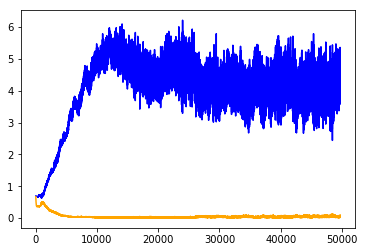

In [82]:
fig = plt.figure()
ax0 =  fig.add_subplot(111)
ax0.plot(gen_loss, c='blue')
ax0.plot(dis_loss, c='orange')
plt.show()

In [83]:
def generate_noise(num=5):
    z = np.random.normal(2, 1, (num, 100))
    z = Variable(Tensor(z))
    return z

In [84]:
z = generate_noise()
img = generator(z)
img = img.detach().numpy().squeeze()

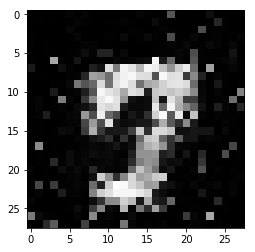

In [89]:
plt.imshow(img[0], cmap='gray')